In [1]:
import pandas as pd
from birdsong_dataset import AudioDataset

In [2]:
df = pd.read_csv("./data/birdsong_metadata.csv")
df.nunique()

file_id                   264
genus                      66
species                    85
english_cname              88
who_provided_recording     68
country                    18
latitude                  195
longitute                 198
type                       54
license                     4
dtype: int64

In [3]:
import numpy as np
import torch
import cv2 as cv
class ToTensor(object):
    def __call__(self, sample):
        image, name , species = sample[0], sample[1],sample[2]
        image = image.transpose((2, 0, 1))
        return torch.from_numpy(image) , torch.from_numpy(name) , torch.from_numpy(species)
    
class ToTensor_noise_red(object):
    def __call__(self, sample):
        image, name , species = sample[0], sample[1],sample[2]

        # image = cv.medianBlur(image,)
        # image = image.astype(np.uint8)
        # image = cv.erode(image , kernel= (5,5) , iterations=3)
        # ret3,image = cv.threshold(image,0,255, cv.ADAPTIVE_THRESH_MEAN_C)
        image = image.reshape((image.shape[0] , image.shape[1] , 1)).transpose((2, 0, 1))
        return torch.from_numpy(image) , torch.from_numpy(name) , torch.from_numpy(species)
    

In [4]:
# dataset_noisy = AudioDataset(metadata_path= "data/birdsong_metadata_test.csv"  , transform = ToTensor(), max_len= 3 , overlapping = 0.5 , noise_reduction=False)
dataset = AudioDataset(metadata_path= "data/birdsong_metadata.csv"  , transform = ToTensor(), max_len= 2 , overlapping = 0 , noise_reduction=False, noise_reduction_level=0.6)

Loading The Data...
Data Loaded !


In [5]:
# from matplotlib import pyplot as plt
# plt.figure(figsize=(10,20))
# counter = 1
# for i in range(4):
#     for j in range(2):
#         plt.subplot(4,2,counter)
#         counter+=1
#         plt.title(dataset[i][1].item())
#         if j % 2 == 0 :
#             plt.imshow(dataset[i][0].to('cpu').numpy().transpose((1,2,0)) , cmap = "grey")
#         else:
#             plt.imshow(dataset_noisy[i][0].to('cpu').numpy().transpose((1,2,0)),  cmap = "grey")
#             

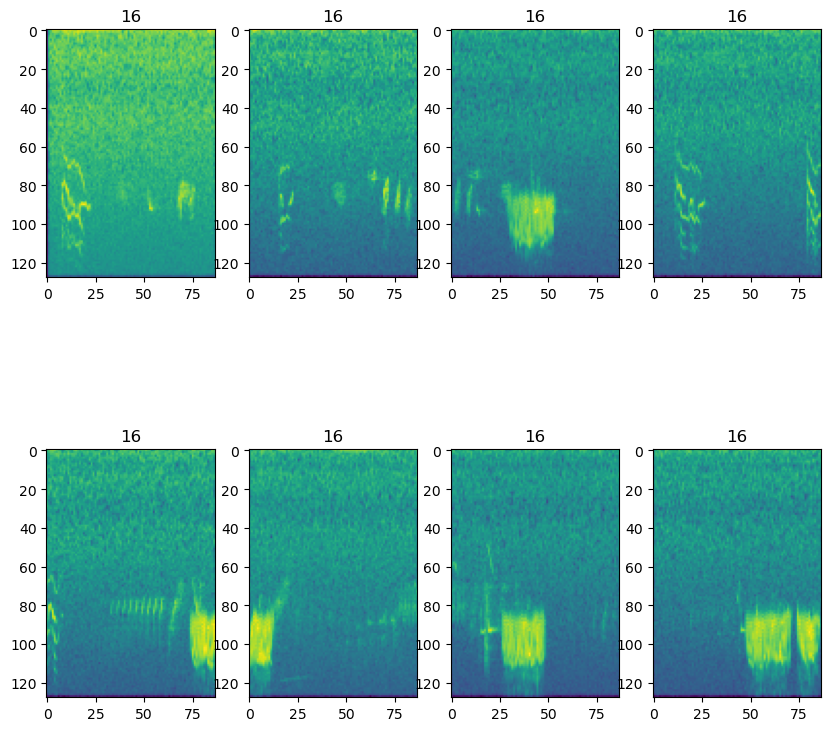

In [6]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,10))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.title(dataset[i][1].item())
    plt.imshow(dataset[i][0].to('cpu').numpy().transpose((1,2,0)))

In [7]:
len(dataset)

8741

In [8]:
from torch import nn
import torch


class BirdSongClassifier(nn.Module):
    def __init__(self, num_classes_1 = 88 , num_classes_2 = 85):
        super(BirdSongClassifier,self).__init__()
        # backbone
        self.conv1 = nn.Conv2d( in_channels=1, out_channels= 64 , kernel_size=3)
        self.norm1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d((3,3))
        self.conv2 = nn.Conv2d( in_channels=64, out_channels=128 , kernel_size=3)
        self.norm2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d((3,3))
        self.conv3 = nn.Conv2d( in_channels=128, out_channels=64 , kernel_size=3)
        self.norm3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d((3,3))
        
        # multilabel classification for name 
        
        self.names_l1 = nn.Linear(64*3*2 ,512 )
        self.names_relu1 = nn.ReLU()
        self.names_l2 = nn.Linear(512 , num_classes_1 )
        
        # multilabel classification for species       
        
        self.species_l1 = nn.Linear(64*3*2 ,512 )
        self.species_relu1 = nn.ReLU()
        self.species_l2 = nn.Linear(512 , num_classes_2 )
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.norm1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        backbone = self.pool3(x)
        # print("Backbone Shape : ", backbone.size())
        #forward for names
        x1 = backbone.view(-1, 64*3*2)
        x1 = self.names_l1(x1.reshape(-1,64*3*2))
        x1 = self.names_relu1(x1)
        x1 = self.names_l2(x1)
        # print("Name Head Shape = " ,x1.shape)

        #forward for species

        x2 = backbone.view(-1, 64*3*2)
        x2 = self.species_l1(x2.reshape(-1,64*3*2))
        x2 = self.species_relu1(x2)
        x2 = self.species_l2(x2)
        return x1  ,x2

    def test_model(self, data_loader):
        """
        Test a model on a specified dataset.
    
        Inputs:
            net - Trained model of type BaseNetwork
            data_loader - DataLoader object of the dataset to test on (validation or test)
        """
        self.eval()
        self.to("cuda")
        true_preds_names, true_preds_species,  count = 0., 0., 0
        
        for imgs, names , species in data_loader: 
            imgs, names , species = imgs.to("cuda"), names.to("cuda") , species.to("cuda")
            with torch.no_grad():
                preds = self(imgs)
                preds_names = preds[0].argmax(dim=-1)
                preds_species = preds[1].argmax(dim=-1)
                true_preds_names += (preds_names == names )[0].sum().item()
                true_preds_species += (preds_species == species )[0].sum().item()
                count += 2
        test_acc = (true_preds_names +  true_preds_species) / count
        return test_acc
model = BirdSongClassifier()
        

In [9]:
from torch.utils.data import random_split, DataLoader


indices = torch.randperm(len(dataset))

# Define the sizes of your desired splits
train_size = int(0.6 * len(dataset))  # 60% of the data for training
val_size = int(0.25 * len(dataset))   # 25% of the data for validation
test_size = len(dataset) - train_size - val_size  # Remaining data for testing

# Use random_split with shuffled indices to create the splits
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

batch_size = 8
# You can then create data loaders for each split if needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, )
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model.test_model( test_loader )

0.006097560975609756

In [11]:
 import time
from torch import optim



# Define loss function and optimizer
criterion_names = nn.CrossEntropyLoss()
criterion_species = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)
model.to("cuda")
max_val_accuracy = 0 
# Training loop
num_epochs = 3000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels_names, labels_species) in enumerate(train_loader):
        
        labels_names , labels_species = labels_names.to("cuda") , labels_species.to("cuda")
        optimizer.zero_grad()
        # Forward pass
        outputs_names , outputs_species = model(inputs.type(torch.cuda.FloatTensor))
        # print(torch.argmax(outputs_names , dim=-1).item(), labels_names.item() ,"-------", torch.argmax(outputs_species , dim=-1).item(), labels_species.item())
        # time.sleep(0.1)
        
        # Calculate loss
        loss_names = criterion_names(outputs_names, labels_names.type(torch.cuda.LongTensor) )
        loss_species = criterion_species(outputs_species, labels_species.type(torch.cuda.LongTensor))
        t_loss_names = loss_names 
        t_loss_species = loss_species
        total_loss = loss_names + loss_species
        # Backward pass
        total_loss.backward()
        # t_loss_species.backward(retain_graph= True)
        # Update weights
        optimizer.step()
        # optimizer_species.step()
        running_loss += total_loss.item()
        # running_loss_species += t_loss_species.item()
        
        # Print statistics every 100 batches
    if (epoch + 1) % 1 == 0:
        train_acc = model.test_model(train_loader) 
        val_acc = model.test_model(val_loader)
        if epoch > 0 and val_acc > 0.6 and val_acc > max_val_accuracy :
            torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, f"best.pt")
            max_val_accuracy = val_acc

        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss : {batch_size * running_loss / len(train_dataset)  :.6f} , Train Acc : {train_acc:.4f}, Val Acc : {val_acc:.8f} , Best Acc : {max_val_accuracy:0.8f}')
    if (epoch + 1) % 10 == 0:
        test_acc = model.test_model(test_loader)
        print(f"TEST ACCURACY : {test_acc:0.4f}")
print('Finished Training')

Epoch [1/3000], Training Loss : 7.437914 , Train Acc : 0.2111, Val Acc : 0.19160584 , Best Acc : 0.00000000
Epoch [2/3000], Training Loss : 7.381929 , Train Acc : 0.1913, Val Acc : 0.22992701 , Best Acc : 0.00000000
Epoch [3/3000], Training Loss : 7.327034 , Train Acc : 0.2332, Val Acc : 0.21167883 , Best Acc : 0.00000000
Epoch [4/3000], Training Loss : 7.274614 , Train Acc : 0.2287, Val Acc : 0.23175182 , Best Acc : 0.00000000
Epoch [5/3000], Training Loss : 7.222326 , Train Acc : 0.2142, Val Acc : 0.20437956 , Best Acc : 0.00000000
Epoch [6/3000], Training Loss : 7.162353 , Train Acc : 0.2370, Val Acc : 0.20072993 , Best Acc : 0.00000000
Epoch [7/3000], Training Loss : 7.115016 , Train Acc : 0.2416, Val Acc : 0.27372263 , Best Acc : 0.00000000
Epoch [8/3000], Training Loss : 7.068863 , Train Acc : 0.2439, Val Acc : 0.21532847 , Best Acc : 0.00000000
Epoch [9/3000], Training Loss : 7.008862 , Train Acc : 0.2713, Val Acc : 0.24817518 , Best Acc : 0.00000000
Epoch [10/3000], Training Lo

KeyboardInterrupt: 

In [18]:
torch.save({
    
            }, "epoch_1000_ta_79_va_67.pt")


In [22]:
device = torch.device("cuda")
model_ft = BirdSongClassifier()
optimizer_ft = optim.SGD(model.parameters(), lr=0.00001)

checkpoint = torch.load("epoch_1000_ta_79_va_67.pt" , map_location= device)
model_ft.load_state_dict(checkpoint['model_state_dict'])
optimizer_ft.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
model_ft.to(device)

BirdSongClassifier(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (names_l1): Linear(in_features=768, out_features=512, bias=True)
  (names_relu1): ReLU()
  (names_l2): Linear(in_features=512, out_features=88, bias=True)
  (species_l1): Linear(

In [23]:
num_epochs = 1000
for epoch in range(num_epochs):
    model_ft.train()
    running_loss = 0.0
    for i, (inputs, labels_names, labels_species) in enumerate(train_loader):
        
        labels_names , labels_species = labels_names.to("cuda") , labels_species.to("cuda")
        optimizer.zero_grad()
        # Forward pass
        outputs_names , outputs_species = model_ft(inputs.type(torch.cuda.FloatTensor))
        # print(torch.argmax(outputs_names , dim=-1).item(), labels_names.item() ,"-------", torch.argmax(outputs_species , dim=-1).item(), labels_species.item())
        # time.sleep(0.1)
        
        # Calculate loss
        loss_names = criterion_names(outputs_names, labels_names.type(torch.cuda.LongTensor) )
        loss_species = criterion_species(outputs_species, labels_species.type(torch.cuda.LongTensor))
        t_loss_names = loss_names 
        t_loss_species = loss_species
        total_loss = loss_names + loss_species
        # Backward pass
        total_loss.backward()
        # t_loss_species.backward(retain_graph= True)
        # Update weights
        optimizer.step()
        # optimizer_species.step()
        running_loss += total_loss.item()
        # running_loss_species += t_loss_species.item()
        
        # Print statistics every 100 batches
    if (epoch + 1) % 1 == 0:
        train_acc = model_ft.test_model(train_loader) 
        val_acc = model_ft.test_model(val_loader)
        
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss : {running_loss :.6f} , Train Acc : {train_acc:.4f}, Val Acc : {val_acc:.8f}')
    

print('Finished Training')

Epoch [1/1000], Training Loss : 1561.648120 , Train Acc : 0.8114, Val Acc : 0.69710145
Epoch [2/1000], Training Loss : 1564.701713 , Train Acc : 0.8271, Val Acc : 0.69565217
Epoch [3/1000], Training Loss : 1572.912654 , Train Acc : 0.8204, Val Acc : 0.68115942
Epoch [4/1000], Training Loss : 1566.559977 , Train Acc : 0.8295, Val Acc : 0.69130435
Epoch [5/1000], Training Loss : 1568.844399 , Train Acc : 0.8126, Val Acc : 0.68405797
Epoch [6/1000], Training Loss : 1569.589457 , Train Acc : 0.8222, Val Acc : 0.71739130
Epoch [7/1000], Training Loss : 1573.738139 , Train Acc : 0.8035, Val Acc : 0.70869565
Epoch [8/1000], Training Loss : 1571.554301 , Train Acc : 0.8235, Val Acc : 0.67101449
Epoch [9/1000], Training Loss : 1572.467697 , Train Acc : 0.8047, Val Acc : 0.69420290
Epoch [10/1000], Training Loss : 1570.607854 , Train Acc : 0.8265, Val Acc : 0.65797101
Epoch [11/1000], Training Loss : 1573.262043 , Train Acc : 0.8253, Val Acc : 0.70724638
Epoch [12/1000], Training Loss : 1568.076

KeyboardInterrupt: 